# Time Series Prediction using RNN (LSTM) for Bike Sharing Dataset
This project uses a London bike-sharing dataset from Kaggle, which contains hourly records of bike rentals in a city, along with associated meteorological and calendar data. The dataset spans across multiple years, providing detailed information for each time unit, such as weather conditions, holidays, and weekend indicators, making it suitable for time series analysis.

Source: https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset

## 1. Data Loading and Initial Exploration

### Import Libraries
import the necessary libraries for data manipulation (Pandas, NumPy), scaling (MinMaxScaler, RobustScaler), plotting (Matplotlib, Seaborn), and model building (TensorFlow, Bokeh for visualization).

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource

### Load Dataset
We load the dataset from Kaggle's London Bike-sharing dataset and explore the first few rows.

In [2]:
data = pd.read_csv('london_merged.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['hour'] = data['timestamp'].dt.hour
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4


### Dataset Description
- **Timestamp**: Date and time of the rental record.
- **CNT**: Total count of bike rentals.
- **T1**: Actual temperature.
- **T2**: Perceived temperature (feels like).
- **Humidity**: Relative humidity percentage.
- **Wind Speed**: Wind speed.
- **Weather Code**: Encoded weather status.
- **Is Holiday**: Whether it is a holiday.
- **Is Weekend**: Whether it is a weekend.
- **Season**: Encoded season.
- **Hour**: Extracted from timestamp, indicating the hour of the record.

## 2. Feature Engineering


### Correlation Analysis
We analyze the correlations between numerical features to remove highly correlated features, reducing model complexity.

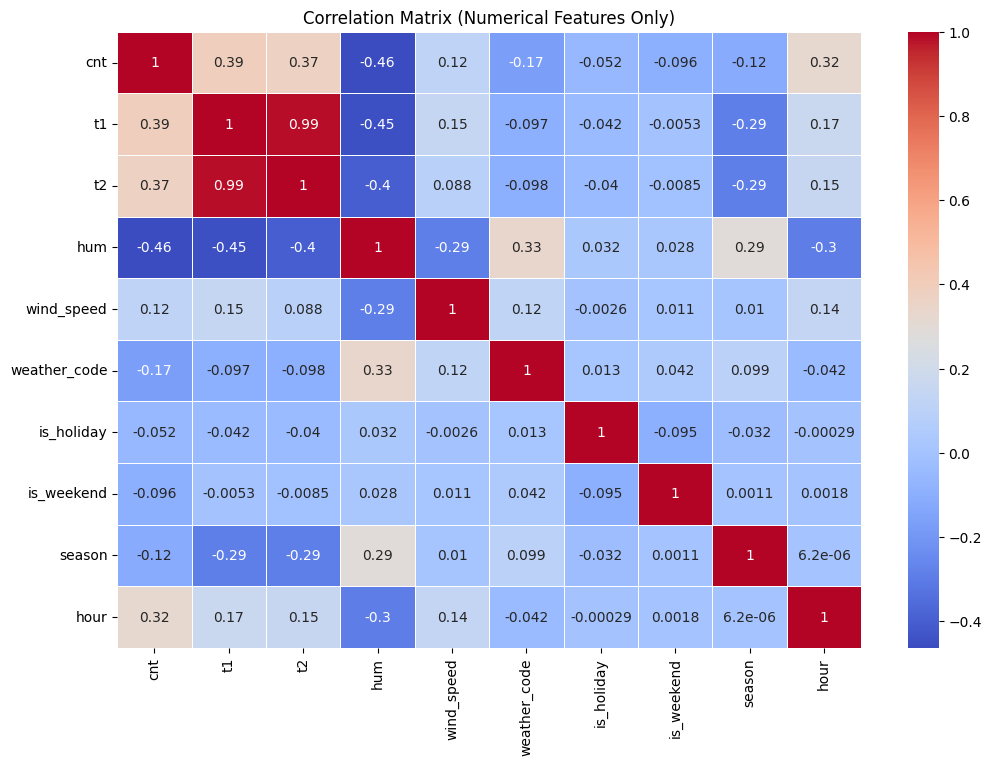

In [3]:
to_drop = ['timestamp']
data_filtered = data.drop(to_drop, axis=1)
corr_matrix = data_filtered.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (Numerical Features Only)')
plt.show()
threshold = 0.85
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

### Removing Highly Correlated Features

In [4]:
data_filtered = data_filtered.drop(high_corr_features, axis=1)
data_filtered.head()

,cnt,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
0,182,3.0,93.0,6.0,3.0,0.0,1.0,3.0,0
1,138,3.0,93.0,5.0,1.0,0.0,1.0,3.0,1
2,134,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2
3,72,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3
4,47,2.0,93.0,6.5,1.0,0.0,1.0,3.0,4


### Categorical Encoding and Normalization
one-hot encoding is applied to categorical features like weather and hour, and normalize numerical features using the `RobustScaler`.


#### Features

In [5]:
data_features = pd.get_dummies(data_filtered, columns=['weather_code', 'is_holiday', 'is_weekend', 'season', 'hour'])
scaler = RobustScaler()
features = data_features.columns
data_features[features[1:]] = scaler.fit_transform(data_features[features[1:]])
data_features.head()

,cnt,t1,hum,wind_speed,weather_code_1.0,weather_code_2.0,weather_code_3.0,weather_code_4.0,weather_code_7.0,weather_code_10.0,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,182,-1.1875,0.925,-0.857143,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,138,-1.1875,0.925,-0.952381,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,134,-1.2500,1.100,-1.428571,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,72,-1.3125,1.275,-1.428571,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47,-1.3125,0.925,-0.809524,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Target

In [6]:
target_scaler = RobustScaler()
data_features['cnt'] = target_scaler.fit_transform(data_features[['cnt']])

### Label Normalization

In [7]:
target_scaler = RobustScaler()
data_features['cnt'] = target_scaler.fit_transform(data_features[['cnt']])
data_features.head()

,cnt,t1,hum,wind_speed,weather_code_1.0,weather_code_2.0,weather_code_3.0,weather_code_4.0,weather_code_7.0,weather_code_10.0,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,-0.467927,-1.1875,0.925,-0.857143,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.499028,-1.1875,0.925,-0.952381,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.501855,-1.2500,1.100,-1.428571,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.545679,-1.3125,1.275,-1.428571,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.563350,-1.3125,0.925,-0.809524,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sequence Creation
Segregation of sequences for LSTM input, using a window of 3 hours (or 168 for full weekly cycles) to capture temporal patterns.

In [8]:
def create_sequences(data, seq_length=3):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        row = data.iloc[i:i+seq_length]
        row_without_cnt = row[features[1:-1]]
        X.append(row_without_cnt.values)
        y.append(row['cnt'])
    return np.array(X), np.array(y)

X, y = create_sequences(data_features, seq_length=168)
X = np.float32(X)
y = np.float32(y)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (17246, 168, 41), y shape: (17246, 168)


## 3. Model Training

### Train-Test Split
We split the data into training (80%) and testing (20%) sets before shuffling, to maintain the time dependency.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train_shuffled, y_train_shuffled = shuffle_in_unison(X_train, y_train)
print(f"Training set shape: X_train_shuffled: {X_train_shuffled.shape}, y_train_shuffled: {y_train_shuffled.shape}")
print(f"Testing set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training set shape: X_train_shuffled: (13796, 168, 41), y_train_shuffled: (13796, 168)
Testing set shape: X_test: (3450, 168, 41), y_test: (3450, 168)


### LSTM Model Architecture
The current architecture of this LSTM model is structured to handle time series data, where the focus is on learning patterns from past observations to make future predictions.

1. **LSTM Layer (32 units)**: This is the main layer of the model that handles sequences of data. It processes the input by storing and updating information over time, which helps it recognize trends and dependencies that happen over several hours or days. The 32 units mean that the model has 32 internal "memory cells" that it uses to track these temporal patterns. We also set `return_sequences=True`, which means that the output at each time step is passed to the next layer instead of just the final output, making it better suited for time series problems.

2. **Dropout Layer (0.3 rate)**: To prevent overfitting, we include a dropout layer, which randomly turns off 30% of the neurons during each training step.

3. **Dense Output Layer (1 unit)**: This is the final layer that takes the processed information from the LSTM and outputs a single value – in this case, the predicted number of bike rentals. Since this is a regression problem (predicting continuous values), we just need one output node without any special activation functions.

In [10]:
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=Huber(), metrics=["mse", 'mae'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 168, 32)             │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 168, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 168, 1)              │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

### Metrics Selection
- **Huber Loss**: This is chosen because it balances between Mean Squared Error (MSE) and Mean Absolute Error (MAE), making it ideal for a dataset like this, which may contain outliers due to extreme weather conditions or sudden changes in user behavior (like holidays). It ensures that outliers don’t overly skew the model while still penalizing significant errors.

- **MSE**: This metric is useful for predicting bike rentals because it heavily penalizes larger errors. In cases where the model might predict far off from the actual rentals (for example, during peak or low rental hours), MSE ensures that these errors are taken into account.

- **MAE**: MAE complements MSE by giving an easy-to-interpret average error in the same unit as the rentals. This helps understand how much, on average, the predicted rentals differ from the actual counts.

These metrics are used together.

### Early Stopping and Reduce Learning Rate
We set early stopping to avoid overfitting and reduce learning rate on plateau to improve convergence.

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr], verbose=1)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 0.1607 - mae: 0.4225 - mse: 0.3715 - val_loss: 0.0330 - val_mae: 0.1665 - val_mse: 0.0691 - learning_rate: 0.0010
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0340 - mae: 0.1765 - mse: 0.0705 - val_loss: 0.0251 - val_mae: 0.1375 - val_mse: 0.0523 - learning_rate: 0.0010
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0278 - mae: 0.1576 - mse: 0.0576 - val_loss: 0.0237 - val_mae: 0.1329 - val_mse: 0.0492 - learning_rate: 0.0010
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0252 - mae: 0.1496 - mse: 0.0521 - val_loss: 0.0244 - val_mae: 0.1345 - val_mse: 0.0505 - learning_rate: 0.0010
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0232 - mae: 0.1444 - mse: 0.0475 - val_loss: 0.0224 - val_mae: 0.1279 - val_mse: 0.0463 - learning_rate: 0.0010
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0222 - mae: 0.1418 - mse: 0.0453 - val_loss: 0.0226 - val_

## 4. Results
Training and validation loss to evaluate the model’s performance.


### Training

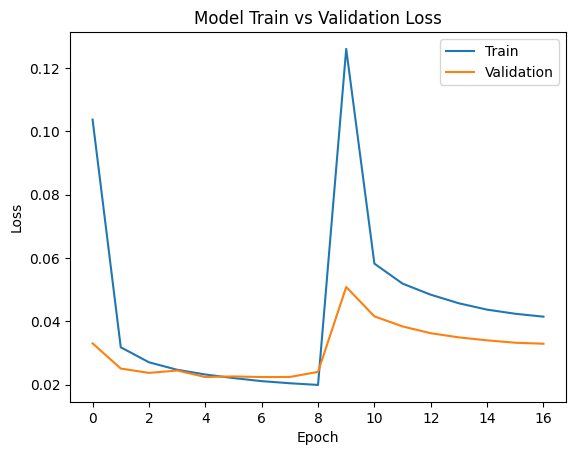

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Prediction and Visualization
Predictions on the test set and a comparison between real and predicted values for the first 100 samples using Bokeh for interactive visualization.


In [15]:
output_notebook()
y_pred = model.predict(X_test)

subset_length = 100
source_subset = ColumnDataSource(data=dict(
    real=y_test[:subset_length],
    predicted=y_pred.flatten()[:subset_length],
    index=list(range(subset_length))
))

p_subset = figure(title="Real vs Predicted Bike Rentals (Subset)", x_axis_label='Index', y_axis_label='Count of Bike Rentals')
p_subset.line('index', 'real', source=source_subset, line_width=2, color='blue', legend_label='Real')
p_subset.line('index', 'predicted', source=source_subset, line_width=2, color='green', legend_label='Predicted')
p_subset.legend.location = "top_left"
show(p_subset)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


## 5. Conclusion
The model performs well, as seen from the close alignment of predicted and actual bike rentals in the graph. It captures the general trends accurately, though it slightly struggles with extreme peaks.

The training vs. validation loss shows a rapid decrease in the first epoch, a peak around the 8th epoch that lowers afterwards. Both losses remain low and converge after a few epochs, with low overfitting.